<div style="text-align: right"> <b>Autor:</b> Michał Bieroński, 218324</div>

### Wykorzystane narzędzie

Wykorzystanym narzędzie jest notatnik jupyter. Językiem programowania jest język python wspierany przez następujące biblioteki:
 - numpy (obliczenia)
 - pandas (manipulacja danymi)
 - matplolib i seaborn (wykresy)

### Informacja na temat wybranych danych

Zbiór danych powiązanych z kampanią marketingową portugalskiej instytucji bankowej. Kampania przeprowadzona została telefonicznie. Często konieczne było nawiązanie wielu kontaktów z klientem w celu uzyskania odpowiedzi na temat subskrypcji depozytu bankowego.

#### Źródło: 
Dane pochodzą z repozytorium: https://archive.ics.uci.edu/ml/datasets/Bank+Marketing

#### Cechy:
   1. age (numeric)
   2. job : type of job (categorical: "admin.","unknown","unemployed","management","housemaid","entrepreneur","student", "blue-collar","self-employed","retired","technician","services") 
   3. marital : marital status (categorical: "married","divorced","single"; note: "divorced" means divorced or widowed)
   4. education (categorical: "unknown","secondary","primary","tertiary")
   5. default: has credit in default? (binary: "yes","no")
   6. balance: average yearly balance, in euros (numeric) 
   7. housing: has housing loan? (binary: "yes","no")
   8. loan: has personal loan? (binary: "yes","no")
   9. contact: contact communication type (categorical: "unknown","telephone","cellular")
   10. day: last contact day of the month (numeric)
   11. month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   12. duration: last contact duration, in seconds (numeric)
   13. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
   14. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric, -1 means client was not previously contacted)
   15. previous: number of contacts performed before this campaign and for this client (numeric)
   16. poutcome: outcome of the previous marketing campaign (categorical: "unknown","other","failure","success")

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [22]:
bank = pd.read_csv('bank.csv', sep=';')
bank.head()

age          job  marital  education default  balance housing loan  \
0   30   unemployed  married    primary      no     1787      no   no   
1   33     services  married  secondary      no     4789     yes  yes   
2   35   management   single   tertiary      no     1350     yes   no   
3   30   management  married   tertiary      no     1476     yes  yes   
4   59  blue-collar  married  secondary      no        0     yes   no   

    contact  day month  duration  campaign  pdays  previous poutcome   y  
0  cellular   19   oct        79         1     -1         0  unknown  no  
1  cellular   11   may       220         1    339         4  failure  no  
2  cellular   16   apr       185         1    330         1  failure  no  
3   unknown    3   jun       199         4     -1         0  unknown  no  
4   unknown    5   may       226         1     -1         0  unknown  no

### Estymacja punktowa

Estymowanym parametrem będzie średni wiek osób będących odbiorcami kampanii marketingowej.

In [23]:
sample = np.random.choice(bank.age, size=10)
sample.mean()

41.5

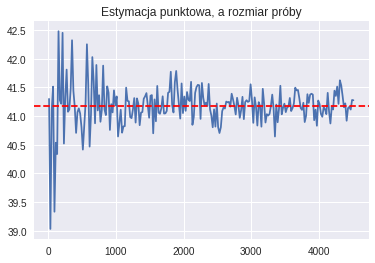

In [24]:
np.random.seed(10)

results = {
    'sample_size': [],
    'mean': []
}

for sample_size in range(10, len(bank), 20):
    sample = np.random.choice(bank.age, size=sample_size)
    results['mean'].append(sample.mean())
    results['sample_size'].append(sample_size)

population_mean = bank.age.mean()

fig, ax = plt.subplots()
ax.plot(results['sample_size'], results['mean'])
ax.axhline(population_mean, c='r', ls='dashed')

_ = ax.set_title('Estymacja punktowa, a rozmiar próby')

Parametr estymowany był za pomocą średniej próbkowej. Powyższy wykres przedstawia otrzymane estymaty wraz ze wzrostem rozmiaru próby. Na czerwowno zaznaczony jest średni wiek dla całej populacji.Łatwo zaobserwować, że:
 - im większy rozmiar próby tym estymacja wartości jest bliżej wartości populacyjnej
 - dla większych rozmiarów próby spada wariancja dla kolejnych prób

### Estymacja przedziałowa

#### Przypadek 1

Chcemy dokonać estymacji przedziałowej średniego wieku odbiorców kampanii.
Założenia:
- wariancja populacji $\sigma^2$ jest znana
- przedział ufności na poziomie 95%

In [25]:
population_std = bank.age.std()

np.random.seed(10)

sample_size = 1000
sample = np.random.choice(bank.age, size=sample_size)
sample_mean = sample.mean()

Ponieważ dystrybucja jest symetryczna należy obliczyć $\frac{\alpha}{2}$

In [26]:
confidence_level = 0.95

alpha = 1 - confidence_level
q = 1 - (alpha / 2)
q

0.975

Teraz można już wyznaczyć wartość $z$ (korzystając z rozkładu normalnego), by później wyznaczyć przedział ufności według wzoru:
$[L, P] = [\bar{x} - z\frac{\sigma}{\sqrt{n}}, \bar{x} + z\frac{\sigma}{\sqrt{n}}]$

Gdzie:
- $\bar{x}$ to średnia próbkowa
- $\sigma$ znane ochylenie standardowe populacji,
- $z$ wartość krytyczna
- $n$ rozmiar próby

In [27]:
z_critical = stats.norm.ppf(q=q)

margin_of_error = z_critical * (population_std / np.sqrt(sample_size))

confidence_interval = (sample_mean - margin_of_error,
                       sample_mean + margin_of_error)  

confidence_interval

(40.353491698718571, 41.66450830128143)

Teraz przedstawiona zostanie wizualizacja przedziałów ufności dla wielu niezależnych prób.

In [28]:
def get_intervals_and_sample_means(q):
    intervals, sample_means = [], []
    
    for _ in range(tries):
        sample = np.random.choice(bank.age, size=sample_size)
        sample_mean = sample.mean()
        sample_means.append(sample_mean)

        z_critical = stats.norm.ppf(q=q)      

        margin_of_error = z_critical * (population_std / np.sqrt(sample_size))

        confidence_interval = (sample_mean - margin_of_error,
                               sample_mean + margin_of_error)  

        intervals.append(confidence_interval)
        
    return intervals, sample_means

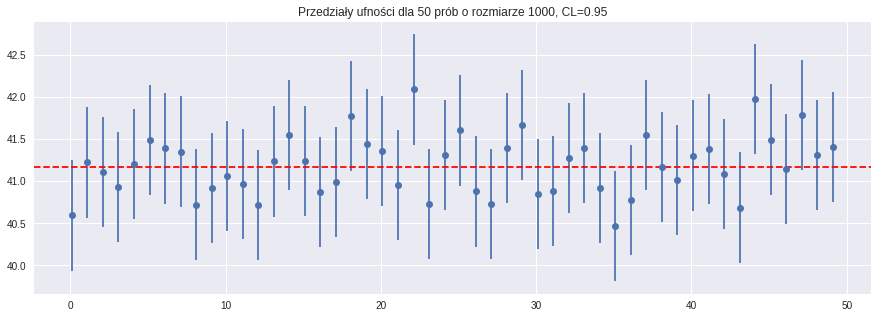

In [29]:
tries = 50

np.random.seed(30)
intervals, sample_means = get_intervals_and_sample_means(q)

fig, ax = plt.subplots(figsize=(15, 5))
ax.errorbar(x=np.arange(0.1, tries, 1),
            y=sample_means, yerr=[(top - bot) / 2 for top, bot in intervals], fmt='o')
ax.axhline(xmax=tries, y=population_mean, c='r', ls='dashed')
_ = ax.set_title(f'Przedziały ufności dla {tries} prób o rozmiarze {sample_size}, CL={confidence_level}')

In [30]:
left, right = intervals[0]
right - left

1.3110166025628587

In [31]:
missed_intervals = np.sum([not left <= population_mean <= right for (left, right) in intervals])
print(f'Missed {missed_intervals} out of {tries} -> {missed_intervals / tries}')

Missed 3 out of 50 -> 0.06


Jk można zauważyć tylko 2-krotnie prawdziwa wartość (czerwona linia) nie została uchwycona w wyznaczonym przedziale ufności. Stanowi to 6% przy 95% przedziale ufności co jest w miarę zgodne z oczekiwaniami. Szerokość przedziału ufności wyniosła około 1,31. Dla porównania zobaczmy jak będzie to wyglądać przy dużo niższym przedziale ufności np. 70%.

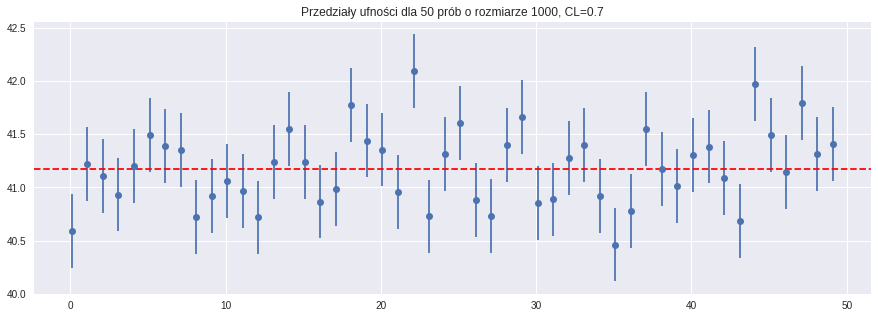

In [32]:
confidence_level = 0.7

q = 1 - ((1 - confidence_level) / 2)

np.random.seed(30)
intervals, sample_means = get_intervals_and_sample_means(q)

fig, ax = plt.subplots(figsize=(15, 5))
ax.errorbar(x=np.arange(0.1, tries, 1),
            y=sample_means, yerr=[(top - bot) / 2 for top, bot in intervals], fmt='o')
ax.axhline(xmax=tries, y=population_mean, c='r', ls='dashed')
_ = ax.set_title(f'Przedziały ufności dla {tries} prób o rozmiarze {sample_size}, CL={confidence_level}')

In [33]:
left, right = intervals[0]
right - left

0.6932685456440737

In [34]:
missed_intervals = np.sum([not left <= population_mean <= right for (left, right) in intervals])
print(f'Missed {missed_intervals} out of {tries} -> {missed_intervals / tries}')

Missed 16 out of 50 -> 0.32


Szerokość przedziału ufności znacznie się skurczyła (do 0,69). W tym przypadku prawdziwa wartość nie zawiera się w przedziale ufności znacznie częściej- konkretnie 16 razy. Procentowo to jest prawie zgodne z założeniem - przy 70% poziomie ufności wartości te poza przedziałem powinny się znaleźć około 30% razy.

### Przypadek 2 - wariancja nie znana

W tym przypadku zamiast korzystać z rozkładu gaussowskiego korzysta się z rozkładu t-studenta. Wariancja estymowana jest na podstawie próby losowej. Warto nadmienić, że dla $n>30$ można korzystać z poprzedniego testu. Dlatego rozmiar próby będzie tu stosunkowo mały. Przyjęty poziom ufności to znowu 95%.

$[L, P] = [\bar{x} - z\frac{S}{\sqrt{n}}, \bar{x} + t\frac{S}{\sqrt{n}}]$

Wzór wygląda podobnie jak ostatnio, z tym że zastąpione tu jest wariancja populacji $\sigma^2$ wariancją próbkową $S^2$.

In [35]:
sample_size = 20
confidence_level = 0.95

q = 1 - ((1 - confidence_level) / 2)

np.random.seed(30)
sample = np.random.choice(bank.age, size=sample_size)

sample_mean = sample.mean()
sample_std = sample.std(ddof=1)

t_critical = stats.t.ppf(q=q, df=sample_size - 1)

margin_of_error = t_critical * sample_std / np.sqrt(sample_size)

confidence_interval = (sample_mean - margin_of_error,
                       sample_mean + margin_of_error)

display(t_critical)
confidence_interval

2.093024054408263

(35.166636888471317, 45.533363111528686)

### Weryfikacja hipotez

Porównanie wartości średnich danej cechy dla dwóch niezależnych prób. Konkretniej średni stan konta pracowników usług vs pracowników technicznych.

Założenia:
- przyjęty poziom istotności $\alpha$ = 0.1
- test $m_1 = m_2$ przeciw:
    - $m_1 > m_2$
    - $m_1 < m_2$
    - $m_1 \ne m_2$        

In [36]:
np.random.seed(10)
services_sample = np.random.choice(bank[bank.job == 'services'].balance, size=900)
technicians_sample = np.random.choice(bank[bank.job == 'technician'].balance, size=1000)

Test zaczynam od otworzenia dwóch niezależnych prób losowych:
- próba rozmiaru 900 dla pracowników usług
- próba rozmiaru 1000 dla pracowników technicznych

In [37]:
def get_T_value(x, y):
    x, y = np.array(x), np.array(y)
    n1 = len(x)
    n2 = len(y)
    
    var_p = ((n1 - 1) * x.var(ddof=1) + (n2 - 1) * y.var(ddof=1)) / (n1 + n2 - 2)
    std_p = np.sqrt(var_p)
    
    t = (x.mean() - y.mean()) / (std_p * np.sqrt(1 / n1 + 1 / n2))
    return t

In [38]:
def test_hypothesis(x, y, significance_level, h_1):
    t = get_T_value(x,y)
    
    q = 1 - (significance_level / 2) if h_1 == 'not_eq' else 1 - significance_level    
    point_value = stats.t.ppf(q=q, df=len(x) + len(y) - 2)
    
    if h_1 == 'not_eq':
        in_critical = t <= -point_value or t >= point_value
        
        print('H1: m1 != m2')
        print(f'C -> t: {t:.4} <= {-point_value:.4} v {t:.4} >= {point_value:.4}')

    elif h_1 == 'greater':
        in_critical = t >= point_value
    
        print('H1: m1 > m2')
        print(f'C -> t: {t:.4} >= {point_value:.4}')

    elif h_1 == 'lesser':
        in_critical = t <= -point_value
        
        print('H1: m1 < m2')
        print(f'C -> t: {t:.4} <= {-point_value:.4}')

    if in_critical:
        print('Wartość t w obszarze krytycznym - odrzucamy H0 na korzyść H1')
    else:
        print('Wartość t nie wystąpiła w obszarze krytycznym - przyjmujemy H0')

In [39]:
significance_level = 0.1

for i, hypothesis in enumerate(['greater', 'lesser', 'not_eq']):
    test_hypothesis(services_sample, technicians_sample, significance_level, hypothesis)
    if i !=2: print('\n')

H1: m1 > m2
C -> t: -2.09 >= 1.282
Wartość t nie wystąpiła w obszarze krytycznym - przyjmujemy H0


H1: m1 < m2
C -> t: -2.09 <= -1.282
Wartość t w obszarze krytycznym - odrzucamy H0 na korzyść H1


H1: m1 != m2
C -> t: -2.09 <= -1.646 v -2.09 >= 1.646
Wartość t w obszarze krytycznym - odrzucamy H0 na korzyść H1


Sprawdźmy jak otrzymane wyniki testów hipotez mają się do wartości średnich w naszych populacjach. Przedstawione zostaną na wykresie słupkowym.

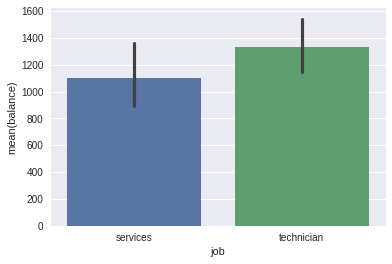

In [40]:
ax = sns.barplot(x='job', y='balance', data=bank[bank.job.isin(['technician', 'services'])])

Patrząc na wykres średniego stanu konta poszczególnych zawodów testy wydają się poprawnie wybierać hipotezy spośród dwóch rozważanych kolejno.